<a href="https://colab.research.google.com/github/VCHULANI15/pricing-options-with-machine-learning/blob/main/Pricing_Options_With_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Price Options Using Machine Learning** / **Vardhan Chulani**

In [21]:
# Import necessary libraries for data manipulation, visualization, machine learning model training, and evaluation. This includes libraries for plotting (matplotlib, seaborn, plotly), machine learning algorithms (sklearn, torch), and data manipulation (numpy, pandas).

import numpy as np
import pandas as pd
import seaborn as sns

#Plot Library
import matplotlib.pyplot as plt
import plotly.express as px
from plotnine import *

#Sklearn Library
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, median_absolute_error, mean_squared_error, r2_score, mean_absolute_error, classification_report
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

#Torch Package
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import norm
from itertools import product


In [22]:
# Set the random seed for reproducibility of results
np.random.seed(42)

# Define the number of samples to generate
n_samples = 100000

# Generate random spot prices uniformly distributed between 50 and 150
Spot = np.random.uniform(50, 150, n_samples)

# Generate random strike prices uniformly distributed between 50 and 150
Strike = np.random.uniform(50, 150, n_samples)

# Generate random time to maturity (TTM) uniformly distributed between 0.25 and 2 years
TTM = np.random.uniform(0.25, 2, n_samples)

# Generate random risk-free interest rates uniformly distributed between 1% and 5%
r = np.random.uniform(0.01, 0.05, n_samples)

# Generate random volatilities uniformly distributed between 10% and 40%, with an additional
# increase of 5% to 15% if the strike price is lower than the spot price
sigma = np.random.uniform(0.1, 0.4, n_samples) + (Strike < Spot) * np.random.uniform(0.05, 0.15, n_samples)

# Create a DataFrame to hold the generated option data including spot price, strike price,
# time to maturity, risk-free rate, and volatility
options_df = pd.DataFrame({
    'Spot Price': Spot,
    'Strike Price': Strike,
    'TTM': TTM,
    'Risk-Free Rate': r,
    'Volatility': sigma
})


In [23]:
# Define the Black-Scholes model function for calculating put option prices
def black_scholes_put_price(Spot, Strike, TTM, r, sigma, q=0):
  # Calculate d1 using the Black-Scholes formula components
  d1 = (np.log(Spot / Strike) + (r - q + 0.5 * sigma ** 2) * TTM) / (sigma * np.sqrt(TTM))
  # Calculate d2 by adjusting d1 with the volatility term
  d2 = d1 - sigma * np.sqrt(TTM)

  # Calculate the put option price using the Black-Scholes formula for puts
  put_price = Strike * np.exp(-r * TTM) * norm.cdf(-d2) - Spot * np.exp(-q * TTM) * norm.cdf(-d1)
  return put_price

# Apply the Black-Scholes model to calculate put prices for each option in the dataframe
options_df['BS_Put_Price'] = black_scholes_put_price(
    options_df['Spot Price'],
    options_df['Strike Price'],
    options_df['TTM'],
    options_df['Risk-Free Rate'],
    options_df['Volatility']
)

# Display the first few rows of the dataframe to check the put price calculations
options_df.head()


,Spot Price,Strike Price,TTM,Risk-Free Rate,Volatility,BS_Put_Price
0,87.454012,108.077904,0.744529,0.016282,0.366686,24.191026
1,145.071431,102.697165,1.052684,0.013820,0.295664,2.102809
2,123.199394,85.103695,0.423627,0.015518,0.229967,0.029113
3,109.865848,99.321266,1.031965,0.028940,0.525141,15.590019
4,65.601864,86.509664,0.605392,0.045381,0.230878,19.065520


In [24]:
# Calculate the absolute difference between spot and strike prices
delta = (options_df['Spot Price'] - options_df['Strike Price']).abs()

# Calculate skew factor; it's higher for options where strike price is less than spot price
skew_factor = np.where(options_df['Strike Price'] < options_df['Spot Price'], delta / options_df['Strike Price'], 0)

# Adjust volatility by adding a random component based on the skew factor
options_df['Adjusted Volatility'] = options_df['Volatility'] + skew_factor * np.random.uniform(0.05, 0.2, n_samples)

# Recalculate the Black-Scholes put price using the adjusted volatility
options_df['Adjusted_BS_Put_Price'] = black_scholes_put_price(
    options_df['Spot Price'],
    options_df['Strike Price'],
    options_df['TTM'],
    options_df['Risk-Free Rate'],
    options_df['Adjusted Volatility']
)

# Display the first few rows of the dataframe to check the adjusted put price calculations
options_df.head()

,Spot Price,Strike Price,TTM,Risk-Free Rate,Volatility,BS_Put_Price,Adjusted Volatility,Adjusted_BS_Put_Price
0,87.454012,108.077904,0.744529,0.016282,0.366686,24.191026,0.366686,24.191026
1,145.071431,102.697165,1.052684,0.013820,0.295664,2.102809,0.328911,2.967925
2,123.199394,85.103695,0.423627,0.015518,0.229967,0.029113,0.315409,0.273305
3,109.865848,99.321266,1.031965,0.028940,0.525141,15.590019,0.537515,16.073277
4,65.601864,86.509664,0.605392,0.045381,0.230878,19.065520,0.230878,19.065520


In [25]:
# Select features for the machine learning model input
X = options_df[['Spot Price', 'Strike Price', 'TTM', 'Risk-Free Rate', 'Volatility']]

# Select the target variable, which is the adjusted Black-Scholes put price
y = options_df['Adjusted_BS_Put_Price']

# Split the dataset into training and testing sets with a test size of 20% and a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Display the shapes of the training and testing feature datasets to verify the split
X_train.shape, X_test.shape


((80000, 5), (20000, 5))

In [26]:
model_list=['lr','dt','rf','gbr','nn']

for i, modelchoice in enumerate(model_list, start=1):
    if (modelchoice == 'lr'):
      globals()[modelchoice + '_model'] = LinearRegression() #LinearRegression
    elif (modelchoice == 'dt'):
      globals()[modelchoice + '_model'] = DecisionTreeRegressor(random_state=42) #LinearRegression
    elif (modelchoice == 'rf'):
      globals()[modelchoice + '_model'] = RandomForestRegressor(n_estimators= 100, random_state = 42) #RandomForestRegressor
    elif (modelchoice == 'gbr'):
      globals()[modelchoice + '_model'] = GradientBoostingRegressor(random_state = 42) #GradientBoostingRegressor
    else:
      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.fit_transform(X_test)
      globals()[modelchoice + '_model'] = MLPRegressor(hidden_layer_sizes =(100, 50), max_iter = 1000, random_state = 42)
      X_test = X_test_scaled
      X_train = X_train_scaled

    globals()[modelchoice + '_model'].fit(X_train, y_train) #ModelFit
    globals()[modelchoice + '_predictions'] = globals()[modelchoice + '_model'].predict(X_test) #Predictions
    globals()[modelchoice + '_mse'] = mean_squared_error(y_test, globals()[modelchoice + '_predictions']) #MSE
    globals()[modelchoice + '_mae'] = mean_absolute_error(y_test, globals()[modelchoice + '_predictions']) #MAE
    globals()[modelchoice + '_r2'] = r2_score(y_test, globals()[modelchoice + '_predictions']) #R2

In [27]:
# Create a DataFrame to compile and compare model performance metrics
results_df = pd.DataFrame({
'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient␣Boosted Trees', 'Neural Network (MLP)'],
'Mean Squared Error': [lr_mse, dt_mse, rf_mse, gbr_mse, nn_mse],
'Mean Absolute Error': [lr_mae, dt_mae, rf_mae, gbr_mae, nn_mae],
'R-squared': [lr_r2, dt_r2, rf_r2, gbr_r2, nn_r2]
})
results_df


,Model,Mean Squared Error,Mean Absolute Error,R-squared
0,Linear Regression,82.306562,7.410646,0.802002
1,Decision Tree,2.223670,1.099779,0.994651
2,Random Forest,0.623588,0.583346,0.998500
3,Gradient␣Boosted Trees,3.012748,1.365971,0.992752
4,Neural Network (MLP),0.137111,0.261362,0.999670


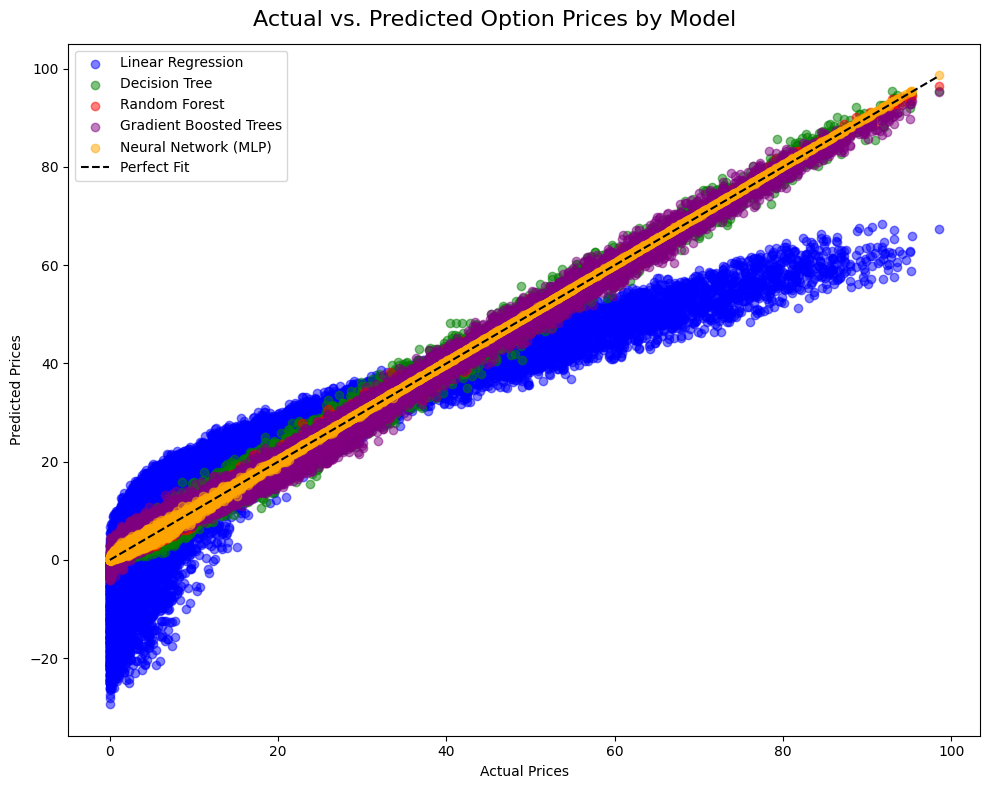

In [28]:
# Set up the figure
plt.figure(figsize=(10, 8))
plt.suptitle('Actual vs. Predicted Option Prices by Model', fontsize=16)

# Plot Linear Regression predictions
plt.scatter(y_test, lr_predictions, alpha=0.5, color='blue', label='Linear Regression')

# Plot Decision Tree predictions
plt.scatter(y_test, dt_predictions, alpha=0.5, color='green', label='Decision Tree')

# Plot Random Forest predictions
plt.scatter(y_test, rf_predictions, alpha=0.5, color='red', label='Random Forest')

# Plot Gradient Boosted Trees predictions
plt.scatter(y_test, gbr_predictions, alpha=0.5, color='purple', label='Gradient Boosted Trees')

# Plot Neural Network predictions
plt.scatter(y_test, nn_predictions, alpha=0.5, color='orange', label='Neural Network (MLP)')

# Plot the line of perfect fit for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', label='Perfect Fit')

# Setting labels and title
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.tight_layout()
plt.show()
